In [1]:
import os
from tqdm import tqdm

import pandas as pd
import numpy as np

import torch

import cv2
from PIL import Image
import warnings

import numpy as np
import pandas as pd

from PIL import Image

import torch
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## image processing

In [3]:
from torchvision import transforms

train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])


test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## load test sets

In [6]:

dataset_dir = '/home/featurize/data'
test_path = os.path.join(dataset_dir, 'val')
from torchvision import datasets

test_dataset = datasets.ImageFolder(test_path, test_transform)
print('Number of test set images', len(test_dataset))
print('Number of categories', len(test_dataset.classes))
print('Name of each category', test_dataset.classes)

idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()

classes = list(idx_to_labels.values())
print(classes)

Number of test set images 898
Number of categories 25
Name of each category ['Cherrytomatoes', 'Mangosteen', 'MomordicaCharantia', 'NavelOrange', 'Sandsugaroranges', 'apple', 'banana', 'carrot', 'cherries', 'cucumber', 'durian', 'grape', 'hamimelon', 'kiwi', 'lemon', 'lichee', 'longan', 'mango', 'pear', 'pineapple', 'pitaya', 'pomegranate', 'strawberry', 'tomato', 'watermelon']
['CherryTomatoes', 'Mangosteen', 'MomordicaCharantia', 'NavelOrange', 'Sandsugaroranges', 'apple', 'banana', 'carrot', 'cherries', 'cucumber', 'durian', 'grape', 'hamimelon', 'kiwi', 'lemon', 'lichee', 'longan', 'mango', 'pear', 'pineapple', 'pitaya', 'pomegranate', 'strawberry', 'tomato', 'watermelon']


In [7]:
model = torch.load('/home/featurize/fruit25_pytorch.pth')
model = model.eval().to(device)

## Form A - Test Set Image Path and Annotation

In [8]:
test_dataset.imgs[:10]

[('/home/featurize/data/val/Cherrytomatoes/100.jpeg', 0),
 ('/home/featurize/data/val/Cherrytomatoes/102.jpeg', 0),
 ('/home/featurize/data/val/Cherrytomatoes/114.jpg', 0),
 ('/home/featurize/data/val/Cherrytomatoes/12.jpg', 0),
 ('/home/featurize/data/val/Cherrytomatoes/132.png', 0),
 ('/home/featurize/data/val/Cherrytomatoes/135.jpeg', 0),
 ('/home/featurize/data/val/Cherrytomatoes/138.jpeg', 0),
 ('/home/featurize/data/val/Cherrytomatoes/144.jpeg', 0),
 ('/home/featurize/data/val/Cherrytomatoes/150.jpg', 0),
 ('/home/featurize/data/val/Cherrytomatoes/151.jpg', 0)]

In [9]:
img_paths = [each[0] for each in test_dataset.imgs]

In [10]:
df = pd.DataFrame()
df['image path'] = img_paths
df['Labelled category ID'] = test_dataset.targets
df['Name of labelling category'] = [idx_to_labels[ID] for ID in test_dataset.targets]

In [11]:
df

,image path,Labelled category ID,Name of labelling category
0,/home/featurize/data/val/Cherrytomatoes/100.jpeg,0,CherryTomatoes
1,/home/featurize/data/val/Cherrytomatoes/102.jpeg,0,CherryTomatoes
2,/home/featurize/data/val/Cherrytomatoes/114.jpg,0,CherryTomatoes
3,/home/featurize/data/val/Cherrytomatoes/12.jpg,0,CherryTomatoes
4,/home/featurize/data/val/Cherrytomatoes/132.png,0,CherryTomatoes
...,...,...,...
893,/home/featurize/data/val/watermelon/60.jpg,24,watermelon
894,/home/featurize/data/val/watermelon/69.jpg,24,watermelon
895,/home/featurize/data/val/watermelon/72.jpg,24,watermelon
896,/home/featurize/data/val/watermelon/87.jpg,24,watermelon


## Table B - Image classification prediction results for each image in the test set, and confidence levels for each category

In [82]:
n = 3

In [25]:
df_pred = pd.DataFrame()
for idx, row in tqdm(df.iterrows()):
    img_path = row['image path']
    img_pil = Image.open(img_path).convert('RGB')
    input_img = test_transform(img_pil).unsqueeze(0).to(device) 
    pred_logits = model(input_img) 
    pred_softmax = F.softmax(pred_logits, dim=1) 

    pred_dict = {}

    top_n = torch.topk(pred_softmax, n) 
    pred_ids = top_n[1].cpu().detach().numpy().squeeze() 
    
   
    for i in range(1, n+1):
        pred_dict['top-{}-anticipateID'.format(i)] = pred_ids[i-1]
        pred_dict['top-{}-Forecast name'.format(i)] = idx_to_labels[pred_ids[i-1]]
    pred_dict['top-nThe prediction is correct.'] = row['Labelled category ID'] in pred_ids

    for idx, each in enumerate(classes):
        pred_dict['{}-predictive confidence'.format(each)] = pred_softmax[0][idx].cpu().detach().numpy()
        
    df_pred = df_pred._append(pred_dict, ignore_index=True)

898it [00:14, 62.65it/s]


In [26]:
df_pred

,top-1-anticipateID,top-1-Forecast name,top-2-anticipateID,top-2-Forecast name,top-3-anticipateID,top-3-Forecast name,top-nThe prediction is correct.,CherryTomatoes-predictive confidence,Mangosteen-predictive confidence,MomordicaCharantia-predictive confidence,...,lichee-predictive confidence,longan-predictive confidence,mango-predictive confidence,pear-predictive confidence,pineapple-predictive confidence,pitaya-predictive confidence,pomegranate-predictive confidence,strawberry-predictive confidence,tomato-predictive confidence,watermelon-predictive confidence
0,23,tomato,0,CherryTomatoes,4,Sandsugaroranges,True,0.26036447,4.4168155e-05,0.07015893,...,0.0047822846,0.001519559,0.0010782323,0.009590035,0.00024912244,9.9706285e-06,0.089687474,0.0050746324,0.29269785,0.0011722024
1,0,CherryTomatoes,23,tomato,21,pomegranate,True,0.836611,2.2777827e-07,2.3127923e-07,...,0.0007222292,4.7509056e-06,4.381268e-09,1.3522928e-08,1.0433896e-06,1.9887636e-08,0.057681553,0.007154159,0.08399635,0.00012616592
2,0,CherryTomatoes,23,tomato,22,strawberry,True,0.803742,4.3960804e-11,2.8811155e-05,...,1.0800217e-07,1.5505942e-09,8.3503215e-10,2.8664038e-09,2.7818368e-08,2.5423404e-07,1.3610563e-06,0.0013396714,0.19484459,1.1961149e-05
3,0,CherryTomatoes,23,tomato,22,strawberry,True,0.5514868,4.232131e-05,0.0078256065,...,0.003741675,0.0004215505,8.881233e-05,0.00074239424,1.941975e-05,0.0003476235,0.00928115,0.015397812,0.393938,0.0013274616
4,23,tomato,0,CherryTomatoes,22,strawberry,True,0.30259857,1.2763355e-08,0.00013640348,...,7.982577e-06,3.4089148e-06,4.8192665e-06,4.0362735e-05,6.4222486e-06,6.4831125e-05,0.00010725227,0.0011213641,0.69348055,0.00047966294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,24,watermelon,23,tomato,21,pomegranate,True,0.004059687,3.058016e-05,0.0010138295,...,0.00015181396,1.4960139e-05,0.012210682,0.0022645153,1.4810878e-06,0.00016644316,0.023554714,0.001752194,0.031093815,0.9072768
894,23,tomato,0,CherryTomatoes,24,watermelon,True,0.23373085,0.00010185334,0.001817428,...,0.00081834546,0.00083806633,0.032998115,0.0102767,0.0005144706,0.008718858,0.005906715,0.01192597,0.3445268,0.15584187
895,24,watermelon,17,mango,21,pomegranate,True,0.028711924,0.0039228513,0.00034540388,...,0.00720253,8.654674e-05,0.28225094,0.0032525025,0.00091111904,0.01326404,0.18394229,0.056317646,0.02317202,0.2887213
896,9,cucumber,24,watermelon,2,MomordicaCharantia,True,0.0020162035,0.0060034716,0.22934264,...,0.0020364951,0.0038040737,0.01873162,0.030937128,0.0068887966,0.00060927344,0.0013321628,0.019240033,0.0029600512,0.26681882


## Splice the two AB forms

In [27]:
df = pd.concat([df, df_pred], axis=1)

In [28]:
df

,image path,Labelled category ID,Name of labelling category,top-1-anticipateID,top-1-Forecast name,top-2-anticipateID,top-2-Forecast name,top-3-anticipateID,top-3-Forecast name,top-nThe prediction is correct.,...,lichee-predictive confidence,longan-predictive confidence,mango-predictive confidence,pear-predictive confidence,pineapple-predictive confidence,pitaya-predictive confidence,pomegranate-predictive confidence,strawberry-predictive confidence,tomato-predictive confidence,watermelon-predictive confidence
0,/home/featurize/data/val/Cherrytomatoes/100.jpeg,0,CherryTomatoes,23,tomato,0,CherryTomatoes,4,Sandsugaroranges,True,...,0.0047822846,0.001519559,0.0010782323,0.009590035,0.00024912244,9.9706285e-06,0.089687474,0.0050746324,0.29269785,0.0011722024
1,/home/featurize/data/val/Cherrytomatoes/102.jpeg,0,CherryTomatoes,0,CherryTomatoes,23,tomato,21,pomegranate,True,...,0.0007222292,4.7509056e-06,4.381268e-09,1.3522928e-08,1.0433896e-06,1.9887636e-08,0.057681553,0.007154159,0.08399635,0.00012616592
2,/home/featurize/data/val/Cherrytomatoes/114.jpg,0,CherryTomatoes,0,CherryTomatoes,23,tomato,22,strawberry,True,...,1.0800217e-07,1.5505942e-09,8.3503215e-10,2.8664038e-09,2.7818368e-08,2.5423404e-07,1.3610563e-06,0.0013396714,0.19484459,1.1961149e-05
3,/home/featurize/data/val/Cherrytomatoes/12.jpg,0,CherryTomatoes,0,CherryTomatoes,23,tomato,22,strawberry,True,...,0.003741675,0.0004215505,8.881233e-05,0.00074239424,1.941975e-05,0.0003476235,0.00928115,0.015397812,0.393938,0.0013274616
4,/home/featurize/data/val/Cherrytomatoes/132.png,0,CherryTomatoes,23,tomato,0,CherryTomatoes,22,strawberry,True,...,7.982577e-06,3.4089148e-06,4.8192665e-06,4.0362735e-05,6.4222486e-06,6.4831125e-05,0.00010725227,0.0011213641,0.69348055,0.00047966294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,/home/featurize/data/val/watermelon/60.jpg,24,watermelon,24,watermelon,23,tomato,21,pomegranate,True,...,0.00015181396,1.4960139e-05,0.012210682,0.0022645153,1.4810878e-06,0.00016644316,0.023554714,0.001752194,0.031093815,0.9072768
894,/home/featurize/data/val/watermelon/69.jpg,24,watermelon,23,tomato,0,CherryTomatoes,24,watermelon,True,...,0.00081834546,0.00083806633,0.032998115,0.0102767,0.0005144706,0.008718858,0.005906715,0.01192597,0.3445268,0.15584187
895,/home/featurize/data/val/watermelon/72.jpg,24,watermelon,24,watermelon,17,mango,21,pomegranate,True,...,0.00720253,8.654674e-05,0.28225094,0.0032525025,0.00091111904,0.01326404,0.18394229,0.056317646,0.02317202,0.2887213
896,/home/featurize/data/val/watermelon/87.jpg,24,watermelon,9,cucumber,24,watermelon,2,MomordicaCharantia,True,...,0.0020364951,0.0038040737,0.01873162,0.030937128,0.0068887966,0.00060927344,0.0013321628,0.019240033,0.0029600512,0.26681882


## Export complete table

In [29]:
df.to_csv('Test sets prediction results.csv', index=False)

In [30]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()
classes = list(idx_to_labels.values())
print(classes)

['CherryTomatoes', 'Mangosteen', 'MomordicaCharantia', 'NavelOrange', 'Sandsugaroranges', 'apple', 'banana', 'carrot', 'cherries', 'cucumber', 'durian', 'grape', 'hamimelon', 'kiwi', 'lemon', 'lichee', 'longan', 'mango', 'pear', 'pineapple', 'pitaya', 'pomegranate', 'strawberry', 'tomato', 'watermelon']


In [31]:
sum(df['Name of labelling category'] == df['top-1-Forecast name']) / len(df)

0.6269487750556793

In [32]:
from sklearn.metrics import classification_report

In [33]:
print(classification_report(df['Name of labelling category'], df['top-1-Forecast name'], target_names=classes))

                    precision    recall  f1-score   support

    CherryTomatoes       0.42      0.71      0.52        38
        Mangosteen       0.78      0.80      0.79        35
MomordicaCharantia       0.55      0.80      0.65        35
       NavelOrange       0.51      0.51      0.51        37
  Sandsugaroranges       0.53      0.83      0.64        35
             apple       0.84      0.74      0.79        35
            banana       0.67      0.11      0.19        36
            carrot       0.73      0.53      0.61        36
          cherries       0.68      0.59      0.63        32
          cucumber       0.54      0.63      0.58        35
            durian       0.94      0.47      0.63        36
             grape       0.86      0.84      0.85        38
         hamimelon       0.65      0.59      0.62        37
              kiwi       0.80      0.43      0.56        37
             lemon       0.51      0.83      0.63        29
            lichee       0.78      0.47

In [34]:
report = classification_report(df['Name of labelling category'], df['top-1-Forecast name'], target_names=classes, output_dict=True)
del report['accuracy']
df_report = pd.DataFrame(report).transpose()

In [35]:
df_report

,precision,recall,f1-score,support
CherryTomatoes,0.415385,0.710526,0.524272,38.0
Mangosteen,0.777778,0.800000,0.788732,35.0
MomordicaCharantia,0.549020,0.800000,0.651163,35.0
NavelOrange,0.513514,0.513514,0.513514,37.0
Sandsugaroranges,0.527273,0.828571,0.644444,35.0
apple,0.838710,0.742857,0.787879,35.0
banana,0.666667,0.111111,0.190476,36.0
carrot,0.730769,0.527778,0.612903,36.0
cherries,0.678571,0.593750,0.633333,32.0
cucumber,0.536585,0.628571,0.578947,35.0


In [36]:
accuracy_list = []
for fruit in tqdm(classes):
    df_temp = df[df['Name of labelling category']==fruit]
    accuracy = sum(df_temp['Name of labelling category'] == df_temp['top-1-Forecast name']) / len(df_temp)
    accuracy_list.append(accuracy)

100%|██████████| 25/25 [00:00<00:00, 1104.71it/s]


In [37]:
# Calculate macro-averaged and weighted-averaged accuracies
acc_macro = np.mean(accuracy_list)
acc_weighted = sum(accuracy_list * df_report.iloc[:-2]['support'] / len(df))

accuracy_list.append(acc_macro)
accuracy_list.append(acc_weighted)

df_report['accuracy'] = accuracy_list

In [38]:
df_report

,precision,recall,f1-score,support,accuracy
CherryTomatoes,0.415385,0.710526,0.524272,38.0,0.710526
Mangosteen,0.777778,0.800000,0.788732,35.0,0.800000
MomordicaCharantia,0.549020,0.800000,0.651163,35.0,0.800000
NavelOrange,0.513514,0.513514,0.513514,37.0,0.513514
Sandsugaroranges,0.527273,0.828571,0.644444,35.0,0.828571
apple,0.838710,0.742857,0.787879,35.0,0.742857
banana,0.666667,0.111111,0.190476,36.0,0.111111
carrot,0.730769,0.527778,0.612903,36.0,0.527778
cherries,0.678571,0.593750,0.633333,32.0,0.593750
cucumber,0.536585,0.628571,0.578947,35.0,0.628571


In [39]:
df_report.to_csv('Indicators for assessing accuracy by category.csv', index_label='category')

In [44]:
model = torch.load('/home/featurize/fruit25_pytorch.pth')
model = model.eval().to(device)

In [45]:
from torchvision.models.feature_extraction import create_feature_extractor

In [46]:
model_trunc = create_feature_extractor(model, return_nodes={'avgpool': 'semantic_feature'})

In [47]:
img_path = '/home/featurize/data/val/kiwi/167.png'
img_pil = Image.open(img_path)
input_img = test_transform(img_pil) 
input_img = input_img.unsqueeze(0).to(device)
pred_logits = model_trunc(input_img) 

In [48]:
pred_logits['semantic_feature'].squeeze().detach().cpu().numpy().shape

(512,)

In [49]:
df = pd.read_csv('/home/featurize/Test sets prediction results.csv')

In [50]:
df.head()

,image path,Labelled category ID,Name of labelling category,top-1-anticipateID,top-1-Forecast name,top-2-anticipateID,top-2-Forecast name,top-3-anticipateID,top-3-Forecast name,top-nThe prediction is correct.,...,lichee-predictive confidence,longan-predictive confidence,mango-predictive confidence,pear-predictive confidence,pineapple-predictive confidence,pitaya-predictive confidence,pomegranate-predictive confidence,strawberry-predictive confidence,tomato-predictive confidence,watermelon-predictive confidence
0,/home/featurize/data/val/Cherrytomatoes/100.jpeg,0,CherryTomatoes,23,tomato,0,CherryTomatoes,4,Sandsugaroranges,True,...,4.782285e-03,1.519559e-03,1.078232e-03,9.590035e-03,2.491224e-04,9.970629e-06,0.089687,0.005075,0.292698,0.001172
1,/home/featurize/data/val/Cherrytomatoes/102.jpeg,0,CherryTomatoes,0,CherryTomatoes,23,tomato,21,pomegranate,True,...,7.222292e-04,4.750906e-06,4.381268e-09,1.352293e-08,1.043390e-06,1.988764e-08,0.057682,0.007154,0.083996,0.000126
2,/home/featurize/data/val/Cherrytomatoes/114.jpg,0,CherryTomatoes,0,CherryTomatoes,23,tomato,22,strawberry,True,...,1.080022e-07,1.550594e-09,8.350322e-10,2.866404e-09,2.781837e-08,2.542340e-07,0.000001,0.001340,0.194845,0.000012
3,/home/featurize/data/val/Cherrytomatoes/12.jpg,0,CherryTomatoes,0,CherryTomatoes,23,tomato,22,strawberry,True,...,3.741675e-03,4.215505e-04,8.881233e-05,7.423942e-04,1.941975e-05,3.476235e-04,0.009281,0.015398,0.393938,0.001327
4,/home/featurize/data/val/Cherrytomatoes/132.png,0,CherryTomatoes,23,tomato,0,CherryTomatoes,22,strawberry,True,...,7.982577e-06,3.408915e-06,4.819266e-06,4.036274e-05,6.422249e-06,6.483113e-05,0.000107,0.001121,0.693481,0.000480


## Calculate the semantic features of each image in the test set

In [51]:
encoding_array = []
img_path_list = []

for img_path in tqdm(df['image path']):
    img_path_list.append(img_path)
    img_pil = Image.open(img_path).convert('RGB')
    input_img = test_transform(img_pil).unsqueeze(0).to(device) 
    feature = model_trunc(input_img)['semantic_feature'].squeeze().detach().cpu().numpy() 
    encoding_array.append(feature)
encoding_array = np.array(encoding_array)

100%|██████████| 898/898 [00:10<00:00, 87.61it/s]


In [52]:
encoding_array.shape

(898, 512)

In [53]:
np.save('Test set semantic features.npy', encoding_array)

In [54]:
import seaborn as sns
marker_list = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', '*', 'h', 'H', '+', 'x', 'X', 'D', 'd', '|', '_', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [55]:
class_list = np.unique(df['Name of labelling category'])

In [56]:
class_list

array(['CherryTomatoes', 'Mangosteen', 'MomordicaCharantia',
       'NavelOrange', 'Sandsugaroranges', 'apple', 'banana', 'carrot',
       'cherries', 'cucumber', 'durian', 'grape', 'hamimelon', 'kiwi',
       'lemon', 'lichee', 'longan', 'mango', 'pear', 'pineapple',
       'pitaya', 'pomegranate', 'strawberry', 'tomato', 'watermelon'],
      dtype=object)

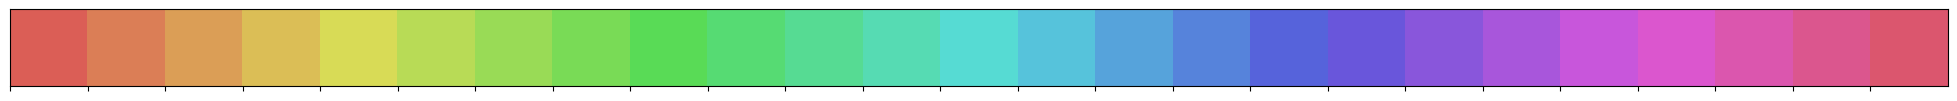

In [57]:
n_class = len(class_list) # Number of test set label categories
palette = sns.hls_palette(n_class) 
sns.palplot(palette)

In [58]:
import random
random.seed(1234)
random.shuffle(marker_list)
random.shuffle(palette)

In [59]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=20000)
X_tsne_2d = tsne.fit_transform(encoding_array)

In [60]:
X_tsne_2d.shape

(898, 2)

In [61]:
show_feature = 'Name of labelling category'

In [63]:
import matplotlib
import matplotlib.pyplot as plt

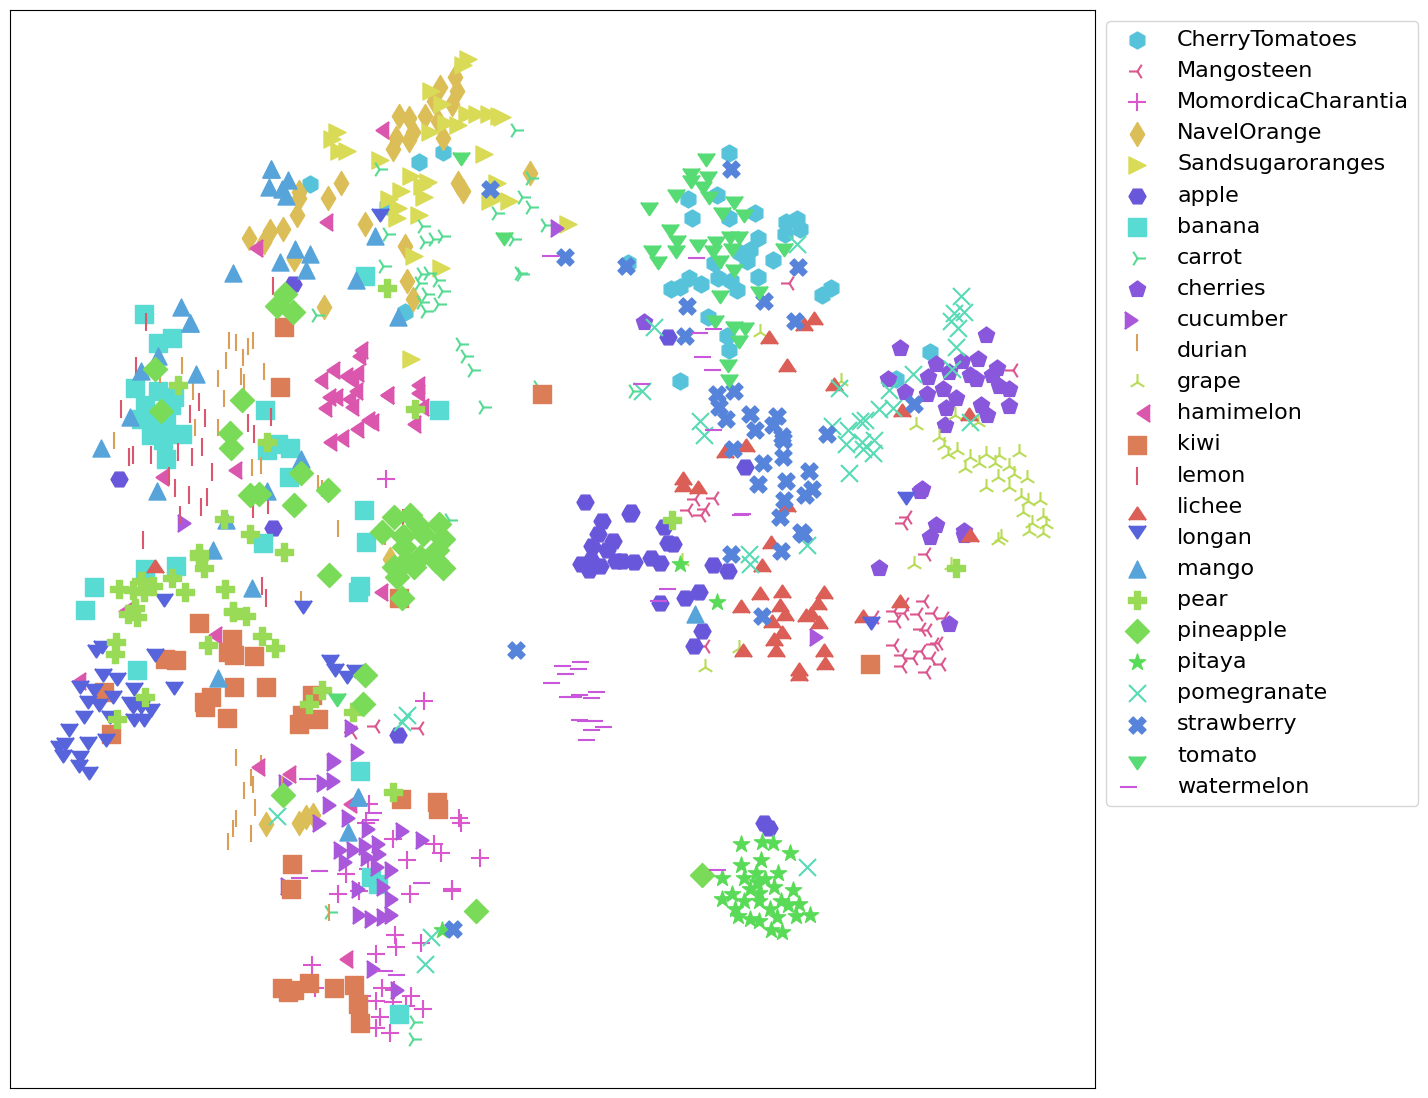

In [64]:
plt.figure(figsize=(14, 14))
for idx, fruit in enumerate(class_list): 
    # Getting colours and point types
    color = palette[idx]
    marker = marker_list[idx%len(marker_list)]

    # Find the index numbers of all images labelled with the category as the current category
    indices = np.where(df[show_feature]==fruit)
    plt.scatter(X_tsne_2d[indices, 0], X_tsne_2d[indices, 1], color=color, marker=marker, label=fruit, s=150)

plt.legend(fontsize=16, markerscale=1, bbox_to_anchor=(1, 1))
plt.xticks([])
plt.yticks([])
plt.savefig('Two-dimensional downscaling visualisation of semantic features t-SNE.pdf', dpi=300) 
plt.show()